# Landscape DOS Neural Net for Box Counting
## 1. Goal
### Backgound
This is a proof of concept project to construct construct $C_1$ and $C_2$ such that $N_{\rm bc}(E)$ best fits the true density of states (DOS) $N(E)$.

More precisely,
- Given a potential $V$ on $L^2(Q_L)$ where $Q_L = [0, L] \cap \mathbb{Z}$ with periodic boundary condition
- Find the DOS, $N(E)$, of the Schrodinger Hamiltonian $-\Delta+V$ where $-\Delta$ is the discrite Laplacian on $\mathbb{Z}$.


### Architecture
The architecture of the neural net (NN) is very simple:
1. 3 layers of CNN + batch normalization + relu
2. 3 dense layers + relu
As before, the inputs are some combinations of $V$, $u$, $W$. The loss function is
$$
    l(C_1 N_{\rm bc}(C_2 E) - N(E))
$$
where $l$ is a simpler loss function such as mean square.






## 2. Import neccessary libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np

# tensorflow
import tensorflow as tf
from tensorflow.keras import layers, Model

# eigenvalue solver
from petsc4py import PETSc
from slepc4py import SLEPc

# Plot
from matplotlib import pylab



## 3. Setting constants

In [2]:
BOXLENGTH = 1000
KERNEL_SIZE = 10
STRIDES = 10
DATA_SIZE = 200
BATCH_SIZE = 32
EPOCHS = 20
V_GEN = lambda x, y : 4.0*np.random.randint(0,2,[x,y]) # random potential: x = batch size, y = boxlength.
CONV_CONST = np.pi**2/8
NEV = 15
EPSILON = np.finfo(np.float32).tiny

## 4. Obtaining training/testing data

## Getting the eigenvalues and the landscape function

In [3]:
class DOS_data_generator():
    # self, list of int, method, int/None, int/None, bool
    def __init__(self, size, nev=NEV, V_gen=None, max_it=None, tol=None, periodic=True):
        self.max_it = max_it
        self.tol=tol
        self.periodic = True
        self.nev = nev
        
        self.V_gen = V_gen
        if V_gen==None:
            self.V_gen = np.random.rand
            
        
        if type(size) == int:
            self.size = [1,size]
        else:
            self.size = size
            
        self.one = PETSc.Vec().createSeq(self.size[1]) 
        self.one[:] = np.ones(self.size[1])
        
    # self, method --> PETSc Mat
    # Makeing a periodic problem Hamiltonian -\Delta+V
    def make_Hamiltonian(self, V):
        n = self.size[1]
        A = PETSc.Mat().create()
        A.setSizes([n, n])
        A.setUp()

        rstart, rend = A.getOwnershipRange()

        # first row
        if rstart == 0:
            A[0, :2] = [2, -1]
            rstart += 1
        # last row
        if rend == n:
            A[n-1, -2:] = [-1, 2]
            rend -= 1
        # other rows
        for i in range(rstart, rend):
            A[i, i-1:i+2] = [-1, 2+V[i], -1]
        # Periodic condition
        if self.periodic:
            A[rstart,rend-1] = -1
            A[rend-1, rstart] = -1

        A.assemble()

        return A

    # self, PETSc Mat --> np array of first nev eigenvalues
    # compute the ground state eigenvalue
    # return -1 if numerical solver is divergent
    def compute_evs(self, Hamiltonian, nev):
        E = SLEPc.EPS()
        E.create()

        E.setOperators(Hamiltonian)
        E.setProblemType(SLEPc.EPS.ProblemType.HEP)
        E.setTolerances(tol=self.tol, max_it=self.max_it)
        E.setWhichEigenpairs(E.Which.SMALLEST_REAL)
        E.setDimensions(nev=nev)

        E.solve()
        
        nconv = E.getConverged()
        #nconv = 34
        if nconv < nev:
            raise ValueError("Eigevanlue solver did not convergence for {} eigenvalue(s)".format(nev-nconv))
        
        res = np.empty(nev, dtype=np.float32)
        for i in range(nev):
            res[i] = E.getEigenvalue(i).real*(1-E.computeError(i)) # gives upper bound
        
        return res
    
    
    # self, PETSc.Mat, bool --> PETSc.Vec
    # use PETSc.Vec.getArray() to convert result to np.ndarray
    def compute_landscape(self, Hamiltonian, show=False):        
        # Create solution landscape function u
        u = PETSc.Vec().createSeq(self.size[1])
        
        # Initialize ksp solver.
        ksp = PETSc.KSP().create()
        ksp.setOperators(Hamiltonian)
        
        # Solve!
        ksp.solve(self.one, u)

        # # Use this to plot the solution (should look like a sinusoid).
        if show:
            pylab.plot(u.getArray())
            pylab.show()
            
        return u   
    
    
    # self, method --> np.ndarray, np.ndarray, np.ndarray
    # return shape: 
    # evs: data_size x nev
    # u: data_size x boxlength
    # V: data_size x boxlength
    # nev: int
    def data_gen(self, V_gen=None, nev=None):
        if V_gen == None:
            V_gen = self.V_gen
        if nev == None:
            nev = self.nev
        
        self.V = V_gen(*self.size)
        #print(self.V)
        self.u = np.empty(self.size, dtype=np.float32)
        self.evs = np.empty([self.size[0], nev], dtype=np.float32)
        
        
        
        for i in range(self.size[0]):
            Hamiltonian = self.make_Hamiltonian(self.V[i])
            self.evs[i] = self.compute_evs(Hamiltonian, nev)
            self.u[i] = self.compute_landscape(Hamiltonian).getArray()
    
            
        return self.evs, self.u, self.V.astype(np.float32), nev

### Example Data Generation

(2, 10) (2, 100) (2, 100)
Setting: discrete 1d integer lattice of size 100.
List of fist 10 eigenvalues:
 [[-0.07155646  0.13784903  0.31824866  0.32568553  0.32572114  0.3283143
   0.32844546  0.53390545  0.7087651   0.7139378 ]
 [ 0.02244142  0.1372368   0.32306436  0.32559687  0.3283127   0.5306174
   0.7648302   0.7652871   0.7811664   0.7984403 ]]
Example of the landscape potential W (orange) and V (blue):


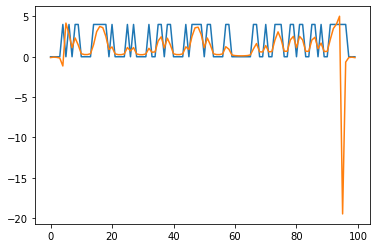

In [4]:
DOS = DOS_data_generator([2,100], nev=10, V_gen=V_GEN)
evs0, u0, V0, nev0 = DOS.data_gen()
print(evs0.shape, u0.shape, V0.shape)
print("Setting: discrete 1d integer lattice of size 100.")
print("List of fist {} eigenvalues:\n".format(10), evs0)
print("Example of the landscape potential W (orange) and V (blue):")

pylab.plot(V0[0])
pylab.plot(1/u0[0])
pylab.show()

In [5]:
# int, int, method --> tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor
# generates:
# dos: (data_size x nev) x 1
# evs: (data_size x nev) x 2
# 1/u, V: (data_size x nev) x boxlength x 1
def _gen_data(data_size=DATA_SIZE, boxlength = BOXLENGTH, nev=NEV, V_gen=None):
    data_generator = DOS_data_generator([data_size, boxlength], nev=nev, V_gen=V_gen)
    evs, u, V, nev = data_generator.data_gen()
    
    #print(evs, u, V, nev)
    # make input by forming nev number of rows for each row in u/V for accommodate the nev eigenvalue/nth 
    # eigenvalue pair
    # shape at the end of this bloc is
    # (make data_size x nev) by boxlength
    zeros = np.zeros([data_size, nev, boxlength], dtype=np.float32)
    u = u[:, np.newaxis,:] + zeros
    u = np.concatenate(u, axis=0)
    V = V[:, np.newaxis,:] + zeros
    V = np.concatenate(V, axis=0)
    
    # (make data_size x nev) length np.array
    evs = np.concatenate(evs)
    evs = evs[..., np.newaxis]
    
    # make DOS target
    dos = np.array(range(1,nev+1), dtype=np.float32)
    dos = np.concatenate(dos+np.zeros([data_size, nev], dtype=np.float32), axis=0)
    dos = dos[..., np.newaxis]
    
    #print("")
    #print(u.shape, V.shape, evs.shape, dos.shape)
    #print("")
    #print(evs, u, V, dos)
    #return
    #evs = tf.concat([evs, 1/np.sqrt(evs)], axis=1)
    #u = tf.convert_to_tensor(u,np.float32)[..., tf.newaxis]
    #V = tf.convert_to_tensor(V,np.float32)[..., tf.newaxis]
    #dos = tf.convert_to_tensor(dos,np.float32)
    
    evs = np.concatenate([evs, 1/np.sqrt(EPSILON+np.maximum(evs, 0.0))], axis=1)
    u = u[..., np.newaxis]
    V = V[..., np.newaxis]
    #rint(dos.shape, evs.shape, u.shape, V.shape)
    
    return dos, evs, 1/u, V, #np.concatenate([u,V], axis=2)

# output is a pair, each of the format: ev, u, V, uV   
def gen_data(data_size=DATA_SIZE, nev=NEV, boxlength = BOXLENGTH, batch_size=BATCH_SIZE, V_gen=None):
    train_ = _gen_data(data_size=data_size*10, nev=nev, boxlength=boxlength, V_gen=V_gen)
    test_ = _gen_data(data_size=data_size, nev=nev, boxlength=boxlength, V_gen=V_gen)
    
    
    train_ds, test_ds = [], []
    for i in range(2):
        train_ds.append(tf.data.Dataset.from_tensor_slices((train_[i+2], train_[1], train_[0])).shuffle(10*data_size).batch(batch_size))
        test_ds.append(tf.data.Dataset.from_tensor_slices((test_[i+2], test_[1], test_[0])).batch(batch_size))
    
    return train_ds, test_ds

In [6]:
train_ds, test_ds = gen_data(data_size=2, nev=3, boxlength=5)
train_ds

[<BatchDataset shapes: ((None, 5, 1), (None, 2), (None, 1)), types: (tf.float32, tf.float32, tf.float32)>,
 <BatchDataset shapes: ((None, 5, 1), (None, 2), (None, 1)), types: (tf.float32, tf.float32, tf.float32)>]

## 5. Box Counting

In [7]:
# input:
# potential: boxlength array x 1
# ev: tf scalar
# output = tf scalar
def box_count(potential, ev):
    ksize = int(tf.math.ceil(1/tf.math.sqrt(ev)))
    #ksize = ksize[..., tf.newaxis]
    #ksize = 3
    #potential = potential[tf.newaxis, ...]
    #print(ksize.shape)
    potential = ev-tf.squeeze(potential)
    
    if ksize < 2:
        count = tf.cast((tf.math.reduce_max(potential) > 0), dtype=np.float32)
        
    else:
        count = 0.0
        for i in range(0,potential.shape[0],ksize):
            if tf.math.reduce_max(potential[i:i+ksize]) > 0:
                count += 1
        #print(ksize)
        #print(ev.shape, potential.shape)
        #print((ev+potential).shape)
        #print(ksize.shape)
        #count = tf.nn.max_pool1d(ev-potential, ksize, ksize, padding='SAME') > 0
    
    #print(count.dtype)
    #print(count)
    #print(potential.shape)
    return tf.cast(count, dtype=np.float32)
    

In [8]:
W0 = 1/u0[0][..., np.newaxis]
ev0 = evs0[0,0] #
#print(W0.shape, ev0)
box_count(W0, 0.9)

<tf.Tensor: id=450, shape=(), dtype=float32, numpy=34.0>

## 6. CNN+fc model

In [9]:
class DOSNN(Model):
    def __init__(self, boxlength=BOXLENGTH, kernel_size=KERNEL_SIZE, strides=STRIDES, input_channel=1, model_name=''):
        super(DOSNN, self).__init__(name='')
        self.model_name = model_name
        
        # input B x 1000 x input_channel -> output B x 100 x 25
        self.conv1a = layers.Conv1D(25, kernel_size, strides=strides, input_shape=(None, boxlength, input_channel))
        self.bn1a = layers.BatchNormalization()

        # input B x 100 x 25 -> output B x 10 x 50 
        self.conv1b = layers.Conv1D(50, kernel_size, strides=strides)
        self.bn1b = layers.BatchNormalization()

        # input B x 10 x 50  -> output B x 1 x 75
        self.conv1c = layers.Conv1D(75, kernel_size, strides=strides)
        self.bn1c = layers.BatchNormalization()
        
        # dense layers for predictions by landscape 
        #self.ufc1 = layers.Dense(5, activation='tanh')
        #self.ufc2 = layers.Dense(5, activation='tanh')
        
        # dense layers for concatenated call(umax/pi^2*8) + CNN output
        self.fc1 = layers.Dense(50, activation='tanh')
        self.fc2 = layers.Dense(20, activation='tanh')
        self.fc3 = layers.Dense(2, activation='softplus')    
        

    # x = potential
    # tp = target prediction by the landscape potential
    def call(self, x, ev, training=False):
        # x has size Batch x BOXLENGTH x channel (==1)
        potential = x
        
        # input B x 1000 x 2 -> output B x 100 x 25
        x = self.conv1a(x)
        x = self.bn1a(x)
        x = tf.nn.relu(x)

        # input B x 100 x 25 -> output B x 10 x 50 
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = tf.nn.relu(x)
        
        #print(x.shape)
        # input B x 10 x 50  -> output B x 1 x 75
        x = self.conv1c(x)
        x = self.bn1c(x)
        x = tf.nn.relu(x)

        # input x: B x 1 x 75 x 1 -> B x 75
        if x.shape[0] == 1:
            x = x[0]
        else:
            x = tf.squeeze(x)
        
        # B x 80
        #print(x.shape, tp.shape)
        x = tf.concat([x,ev], axis=1)
        #print(x.shape)
        
        #print(x.shape)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        # x has shape B x 2
        
        res = []
        for i in range(x.shape[0]):
            #print(x[i][0], potential[i].shape, ev[i][0])
            #print(x[i][1] * ev[i][0])
            
            res.append(x[i][0] * box_count(potential[i], x[i][1] * ev[i][0]))
        
        return tf.convert_to_tensor(res)
        
        
        

### Example 1 forward pass

In [10]:
dos, evs, W, V = _gen_data(data_size=2, nev=3)
dosnn = DOSNN(input_channel=2)
#print(W.shape,evs.shape)
dosnn.call(W, evs)

<tf.Tensor: id=16983, shape=(6,), dtype=float32, numpy=
array([0.        , 0.93905365, 0.93298113, 0.        , 0.        ,
       1.8593873 ], dtype=float32)>

## 7. Training

In [11]:
def train(model, train_ds=None, test_ds=None, epochs=EPOCHS):
    loss_object = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam()
    
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    test_loss = tf.keras.metrics.Mean(name='test_loss')
    
    @tf.function
    def train_step(x, ev, target):
        with tf.GradientTape() as tape:
            #print(x.shape, ev.shape)
            predictions = model(x, ev)
            loss = loss_object(target, predictions)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            train_loss(loss)
            
            
    @tf.function
    def test_step(x, ev, target):
        predictions = model(x, ev)
        t_loss = loss_object(target, predictions)

        test_loss(t_loss)
    
    

    for epoch in range(epochs):
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        test_loss.reset_states()

        for x, ev, target in train_ds:
            train_step(x, ev, target)

        for x, ev, target in test_ds:
            test_step(x, ev, target)

        template = 'Epoch {}, Training Loss: {}, Test Loss: {}'
        print(template.format(epoch+1,
                            train_loss.result(),
                            test_loss.result()))

In [12]:
def compare_models(train_ds, test_ds, epochs=EPOCHS):
    
    # defining models
    models = []
    models.append(DOSNN(input_channel=1, model_name='1/u based'))
    models.append(DOSNN(input_channel=1, model_name='V based'))
    #models.append(DOSNN(input_channel=2, model_name='uV based'))
    
    # training
    for i, model in enumerate(models):
        print("-------------------------------------------")
        print("| Starting training for {} model".format(model.model_name))
        print("-------------------------------------------")
        
        train(model, train_ds=train_ds[i], test_ds=test_ds[i], epochs=epochs)
        print("")
    print("Training finished\n")
    
    # displaying some numerical values
    sample = _gen_data(10)
    print("-------------------------------------------")
    print("| Displaying numerical values for comparison")
    print("-------------------------------------------")
    print("True eigenvalues:")
    print(sample[0])
    
    
    pred = []
    for i in range(len(models)):
        pred.append(models[i](sample[i+2], sample[1]))
        print("")
        print("Results from {} GSNN".format(models[i].model_name))
        print(pred[i])
    

In [13]:
# generating data sets
train_ds, test_ds = gen_data()

In [ ]:
compare_models(train_ds, test_ds)

-------------------------------------------
| Starting training for 1/u based model
-------------------------------------------
